# Exploratory Data Analysis - Uncovering the Relationship Between Spotify Music Listening Behavior and Mental Health Related Search Terms on Google Trends

Authors: Soo Hwan Park and Matt Kenney

## Spotify Data Collection:
To collect spotify data, we choose to analyze song properties from the Top 200 and Viral 50 Spotify Charts, where the Top 200 represent the top 200 most-listened to songs in a given time period, and the Viral 50 represent the fastest "growing" songs on spotify (i.e. songs with the largest number of new listeners within a one-day period).

To collect this data, we pulled the Top 200 and Viral 50 charts for each day ranging from January 1st, 2017, to the present (September 29, 2020). Then, we averaged features such as dancability, energy, loudness, valence, etc. across songs in these charts to make an assessment about the types of music users were listening to on a given day. We restrict our analysis here to data generated by United-States-based listeners.

### Collect Song Charts

In [1]:
import os
import sys
import urllib
import spotipy
import json
import time
import matplotlib
from os import listdir
from pathlib import Path
from urllib import request
from urllib.error import URLError
from matplotlib.pyplot import figure
from pytrends.request import TrendReq
from datetime import date, timedelta, datetime
from spotipy.oauth2 import SpotifyClientCredentials

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def date_as_string(date):
    """ Converts the passed date to a 'YYYY-MM-DD' format date string"""
    return date.strftime("%Y-%m-%d")

In [3]:
def string_as_date(string):
    """ Converts the passed 'YYYY-MM-DD' format date string to a date object """
    return datetime.strptime(string, "%Y-%m-%d").date()

In [4]:
def get_spotify_data(data_dir, url_prefix, start_date, end_date=(date.today() - timedelta(days=1))):
    """ 
    Downloads csvs containing spotify songs from either the viral 50 or top 200 charts for each
    day in the passed date range.
    
    :param: data_dir: the name of the directory that csv files should be saved to
    :param: url_prefix: the url prefix pointing to spotify charts.
    :param: start_date: the first date the user would like to obtain spotify data on
    :param: end_date: the last date the user would like to obtain spotify data on. Defaults to the 
                      current date - 1 day, i.e. the last date that spotify data should be available for.         
    """
    # Spoof a broswer-based user agent so the site won't forbid us from downloading data from a headless agent
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    urllib.request.install_opener(opener)

    # Get ready to download all data
    curr_date = start_date
    data_dir.replace('/', '') # Remove slash from directory name and url_prefix if they were added
    url_prefix.replace('/', '')
    
    # Loop through dates
    while curr_date <= end_date:
        
        curr_url = url_prefix + '/' + date_as_string(curr_date) + '/download'
        data_filename = data_dir + '/' + date_as_string(curr_date) + '.csv'
        
        # Download CSV
        try:
            request.urlretrieve(curr_url, data_filename)
        except URLError as urlError:
            print('The following URL failed:', curr_url)
             
        # Increment
        curr_date += timedelta(days=1)
    

In [5]:
# Date range of the music listening data to collect
start_date = date(2017, 1, 1)
end_date = date(2020, 9, 29)
diff = timedelta(days=1)

In [6]:
# Create some directories to store CSVs
viral_songs_dir = './data/us/viral_songs_data/raw/'
top_songs_dir = './data/us/top_songs_data/raw/'
Path(viral_songs_dir).mkdir(exist_ok=True)
Path(top_songs_dir).mkdir(exist_ok=True)

In [7]:
# Set up vars
region = 'us'
viral_50_url_prefix = 'https://spotifycharts.com/viral/' + region + '/daily'
top_200_url_prefix = 'https://spotifycharts.com/regional/' + region + '/daily'

In [ ]:
# Get Viral 50
get_spotify_data(data_dir=viral_songs_dir, 
                 url_prefix=viral_50_url_prefix, 
                 start_date=start_date, 
                 end_date=end_date)

In [ ]:
# Get Top 200
get_spotify_data(data_dir=top_songs_dir, 
                 url_prefix=top_200_url_prefix, 
                 start_date=start_date, 
                 end_date=end_date)

### Extract song attributes from those song charts

In [8]:
viral_return_path = "./data/us/viral_songs_data/processed/"
top_return_path="./data/us/top_songs_data/processed/"

In [9]:
# Create Spotipy Client & Connect to Server Project
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id="e5cb4e77a72a4317a0720a4645d4ec71",
                                                           client_secret="736358fc434f4945ba0e3735e30e9a01"))

In [ ]:
# Build csv's for viral songs with all their features in the processed folder
for filename in os.listdir(viral_songs_dir):
    
    if filename.endswith('.csv'):
        
        # Create dataframe from csv
        df = pd.read_csv(viral_path + filename)
        urls= df['URL'].tolist()

        # build features table
        features = pd.DataFrame()
        for url in urls:
            feature=sp.audio_features(url)
            jdata = json.loads(json.dumps(feature, indent=4))
            extra = pd.DataFrame(jdata)
            features=features.append(extra,sort=False)
            features=features.reset_index(drop=True)
            
            
        result = pd.concat([df, features], axis=1, sort=False)
        result=result.drop(columns=['URL','type','uri','track_href','analysis_url','id'],axis=1)
        new_file = viral_return_path + filename
        result.to_csv(new_file, index = False)

In [ ]:
# Build csv's for Top songs with all their features in the processed folder
# For top songs, remove first row

for filename in os.listdir(top_path):
    
    if filename.endswith('.csv'):
        
        # Create dataframe from csv
        df = pd.read_csv(top_path + file)
        new_header = df.iloc[0]
        df = df[1:]
        df.columns = new_header
        df = df.reset_index()
        df = df.drop(columns=["index"])

        urls= df['URL'].tolist()

        # build features table
        features = pd.DataFrame()
        for url in urls:
            feature=sp.audio_features(url)
            jdata = json.loads(json.dumps(feature, indent=4))
            extra = pd.DataFrame(jdata)
            features=features.append(extra,sort=False)
            features=features.reset_index(drop=True)
            
        result = pd.concat([df, features], axis=1, sort=False)
        result = result.drop(columns=['URL','type','uri','track_href','analysis_url','id'], axis=1)
        new_file = top_return_path + filename
        result.to_csv(new_file, index = False)

# Exploratory Data Analysis of the Audio Features Data
Here, we aim to create and explore the dataset, where each row represents audio features for that day.

### Set Up

In [10]:
# Set Styling
sns.set_style('dark')
sns.set_palette('RdBu')

In [11]:
# directory where the csv files with audio features are in
top_path = "./data/us/top_songs_data/processed/"

In [12]:
#Clean data and build a list of dataframes for each day
top_master=[]

for filename in os.listdir(top_path):
    if (filename.endswith('.csv')):
        df = pd.read_csv(top_path + filename)
        
        #drop Track Name and Artist as they are unnecessary for audio feature analysis
        df=df.drop(columns=['Track Name','Artist'],axis=1)
        df["date"]=str(filename)[0:10]
        top_master.append(df)

#show sample dataframe
top_master[0].head()

,Position,Streams,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,date
0,1,1430887,0.878,0.619,6,-5.560,1,0.1020,0.0533,0.000000,0.113,0.639,136.041,157067,4,2019-06-01
1,2,1357230,0.701,0.425,7,-10.965,1,0.3750,0.3280,0.130000,0.100,0.562,135.128,194088,4,2019-06-01
2,3,1297549,0.796,0.586,4,-6.946,0,0.1470,0.0247,0.000000,0.132,0.179,97.981,200107,4,2019-06-01
3,4,1206971,0.554,0.498,9,-8.866,1,0.0685,0.2300,0.000006,0.795,0.413,79.635,190067,4,2019-06-01
4,5,1140728,0.876,0.662,2,-6.482,0,0.4260,0.0608,0.000000,0.127,0.844,75.445,163320,4,2019-06-01


## Create a dataframe that summarizes audio features for each day
Average across all audio features in the top 200 in order to determine the average audio features in each category,
for the day

In [13]:
top_avg = pd.DataFrame(columns=["date", "danceability", "energy", "key", "loudness", "mode",
                                "speechiness", "acousticness", "instrumentalness", "liveness",
                                "valence", "tempo", "duration_ms", "time_signature"])

for i in range(len(top_master)):
    danceability=top_master[i]["danceability"].mean()
    energy=top_master[i]["energy"].mean()
    key=top_master[i]["key"].mean()
    loudness=top_master[i]["loudness"].mean()
    mode=top_master[i]["mode"].mean()
    speechiness=top_master[i]["speechiness"].mean()
    acousticness=top_master[i]["acousticness"].mean()
    instrumentalness=top_master[i]["instrumentalness"].mean()
    liveness=top_master[i]["liveness"].mean()
    valence=top_master[i]["valence"].mean()
    tempo=top_master[i]["tempo"].mean()
    duration_ms=top_master[i]["duration_ms"].mean()
    time_signature=top_master[i]["time_signature"].mean()
    df= pd.DataFrame(np.array([[top_master[i].iloc[0]['date'],danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature]]),columns=["date","danceability","energy","key","loudness","mode","speechiness","acousticness","instrumentalness","liveness","valence","tempo","duration_ms","time_signature"])
    top_avg=top_avg.append(df,ignore_index=True)

#show sample dataframe

top_avg.head()

,date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,2019-06-01,0.7137899999999999,0.61041,5.435,-6.532805,0.615,0.139611,0.22321451000000003,0.00662080395,0.1793705,0.4650315,121.173465,196163.5,4.0
1,2017-03-04,0.6850399999999999,0.5992999999999999,4.995,-6.552495,0.595,0.145941,0.20808653999999996,0.006575383650000001,0.1511785,0.43294650000000007,122.18511000000001,225002.31,3.975
2,2019-04-02,0.7171449999999999,0.5791755,5.46,-6.917385,0.555,0.1620815,0.26126046,0.0180092716,0.17425950000000004,0.43655449999999996,120.265905,196145.03,3.985
3,2020-09-02,0.7051900000000001,0.593715,5.5,-6.701065000000001,0.56,0.1273995,0.24727645000000004,0.0082483792,0.16613,0.4491975,122.59538500000001,195894.88,3.935
4,2019-07-23,0.72348,0.60179,5.04,-6.447345,0.64,0.143579,0.22155275500000002,0.00699730385,0.180593,0.46861,119.35453000000001,196235.44,4.02


In [14]:
#Sort the "Average" Dataframe by dates and correct the types to datetime and floats

figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

top_avg['date'] = pd.to_datetime(top_avg['date'])
top_avg = top_avg.sort_values(by=['date'])
top_avg['danceability'] = pd.to_numeric(top_avg['danceability'])
top_avg['energy'] = pd.to_numeric(top_avg['energy'])
top_avg['key'] = pd.to_numeric(top_avg['key'])
top_avg['loudness'] = pd.to_numeric(top_avg['loudness'])
top_avg['mode'] = pd.to_numeric(top_avg['mode'])
top_avg['speechiness'] = pd.to_numeric(top_avg['speechiness'])
top_avg['acousticness'] = pd.to_numeric(top_avg['acousticness'])
top_avg['instrumentalness'] = pd.to_numeric(top_avg['instrumentalness'])
top_avg['liveness'] = pd.to_numeric(top_avg['liveness'])
top_avg['valence'] = pd.to_numeric(top_avg['valence'])
top_avg['tempo'] = pd.to_numeric(top_avg['tempo'])
top_avg['duration_ms'] = pd.to_numeric(top_avg['duration_ms'])
top_avg['time_signature'] = pd.to_numeric(top_avg['time_signature'])

#show sample dataframe

top_avg.head()

,date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
540,2017-01-01,0.681935,0.631440,5.345,-6.834550,0.595,0.133264,0.174817,0.010311,0.172115,0.507134,123.711640,219318.020,4.010
530,2017-01-02,0.676290,0.610385,5.215,-6.780710,0.560,0.141241,0.198055,0.007679,0.159602,0.442370,121.723755,223566.330,3.985
1000,2017-01-03,0.674705,0.608545,5.235,-6.810915,0.555,0.140566,0.198139,0.007680,0.155095,0.439146,121.517035,222978.725,3.985
909,2017-01-04,0.675600,0.606130,5.215,-6.836510,0.555,0.142691,0.202651,0.007679,0.156017,0.437445,121.867565,222926.035,3.985
863,2017-01-05,0.678950,0.609420,5.240,-6.769335,0.560,0.146080,0.199928,0.007648,0.158186,0.442190,122.244085,223008.005,3.985


<Figure size 1600x800 with 0 Axes>

This section provides visualization of how the average value of each audio feature changed over time. The ones of interest are "Energy", "Danceability", "Speechiness", "Acousticness", "Instrumentalness", "Liveness", and "Valence", which are based on a confidence measure of 0.0 to 1.0 of whether the track has that attribute. For example, 1.0 for "Acousticness" represents high confidence the track is acoustic.

**Energy**: Serves as a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

**Danceability**: Detects how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity.

**Speechiness**: Detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

**Acousticness**: Detects the acousticness of a track.

**Instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.

**Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

**Valence**: Describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

*All descriptions are based on Spotify API's "Get Audio Features for a Track": https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/"

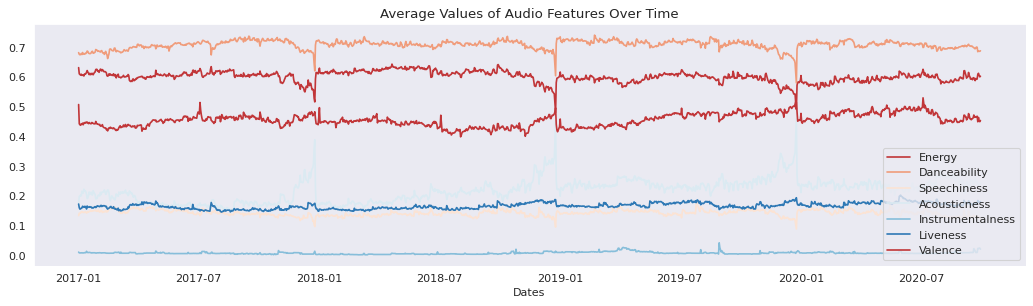

In [15]:
#Average Values of Audio features over time
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(top_avg["date"]),np.array(top_avg["energy"]),label="Energy")
plt.plot(np.array(top_avg["date"]),np.array(top_avg["danceability"]),label="Danceability")
plt.plot(np.array(top_avg["date"]),np.array(top_avg["speechiness"]),label="Speechiness")
plt.plot(np.array(top_avg["date"]),np.array(top_avg["acousticness"]),label="Acousticness")
plt.plot(np.array(top_avg["date"]),np.array(top_avg["instrumentalness"]),label="Instrumentalness")
plt.plot(np.array(top_avg["date"]),np.array(top_avg["liveness"]),label="Liveness")
plt.plot(np.array(top_avg["date"]),np.array(top_avg["valence"]),label="Valence")

plt.title('Average Values of Audio Features Over Time')
plt.xlabel('Dates')
plt.legend(title="",loc=4)

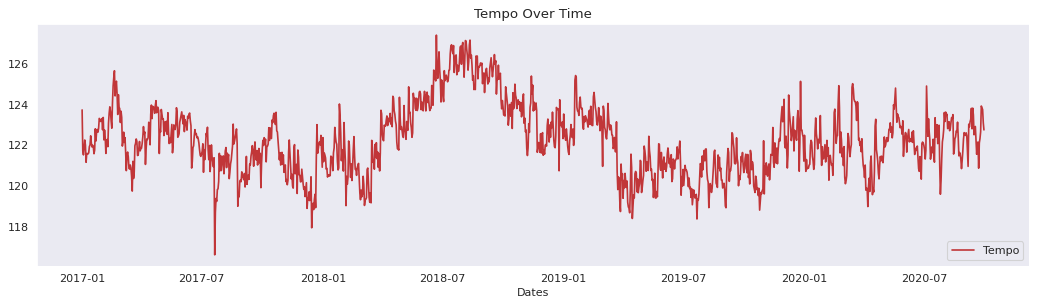

In [16]:
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(top_avg["date"]),np.array(top_avg["tempo"]),label="Tempo")
plt.title('Tempo Over Time')
plt.xlabel('Dates')
plt.legend(title="",loc=4)

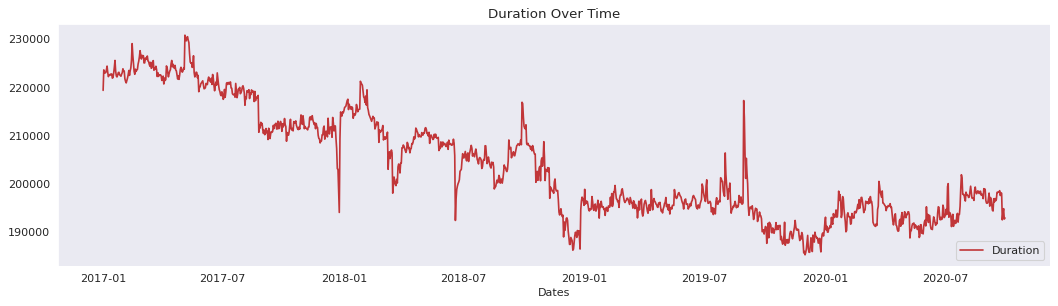

In [17]:
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(top_avg["date"]),np.array(top_avg["duration_ms"]),label="Duration")
plt.title('Duration Over Time')
plt.xlabel('Dates')
plt.legend(title="",loc=4)

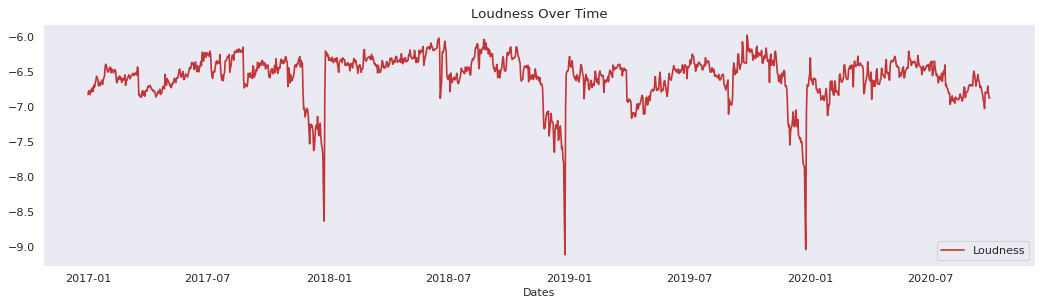

In [18]:
figure(num=None, figsize=(16, 4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(np.array(top_avg["date"]),np.array(top_avg["loudness"]),label="Loudness")
plt.title('Loudness Over Time')
plt.xlabel('Dates')
plt.legend(title="",loc=4)

## Histograms Representing the Frequencies of Each Audio Feature

Histograms for All Song Attributes


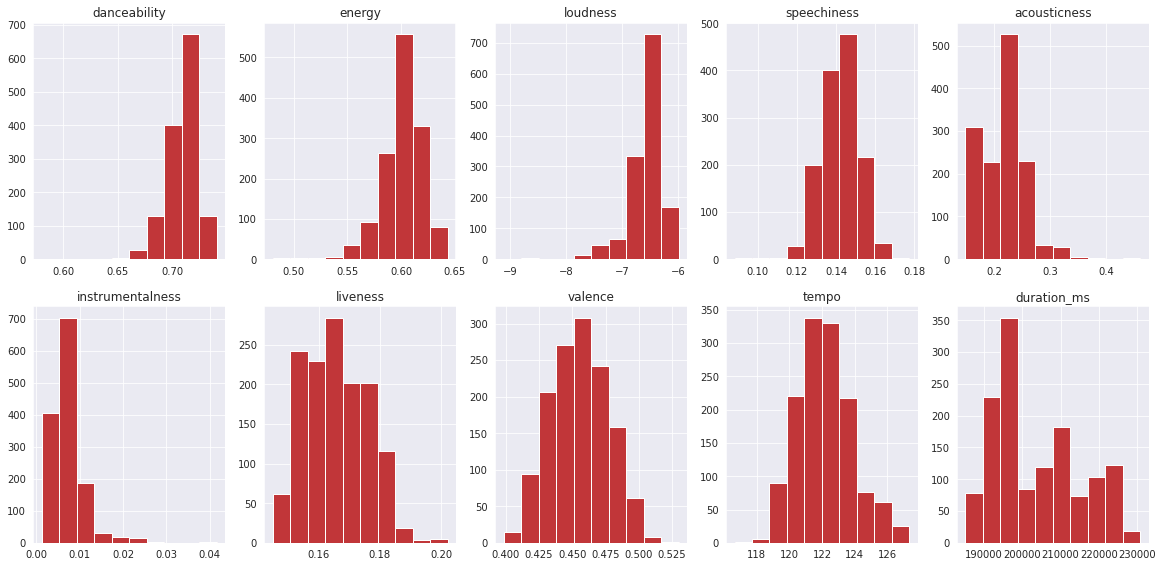

In [19]:
print('Histograms for All Song Attributes')
attributes_only = top_avg.drop(columns=['date', 'key', 'mode', 'time_signature'])
for n, col in enumerate(attributes_only.columns):
    plt.subplot(4, 5, n+1)
    plt.title(col)
    attributes_only[col].hist(ax = plt.gca(), figsize=(20, 20))

## Pairplot showing the interrelationships between song attributes.
Attribute combinations which show linear patterns indicate that there is a colinearity between the two song attributes

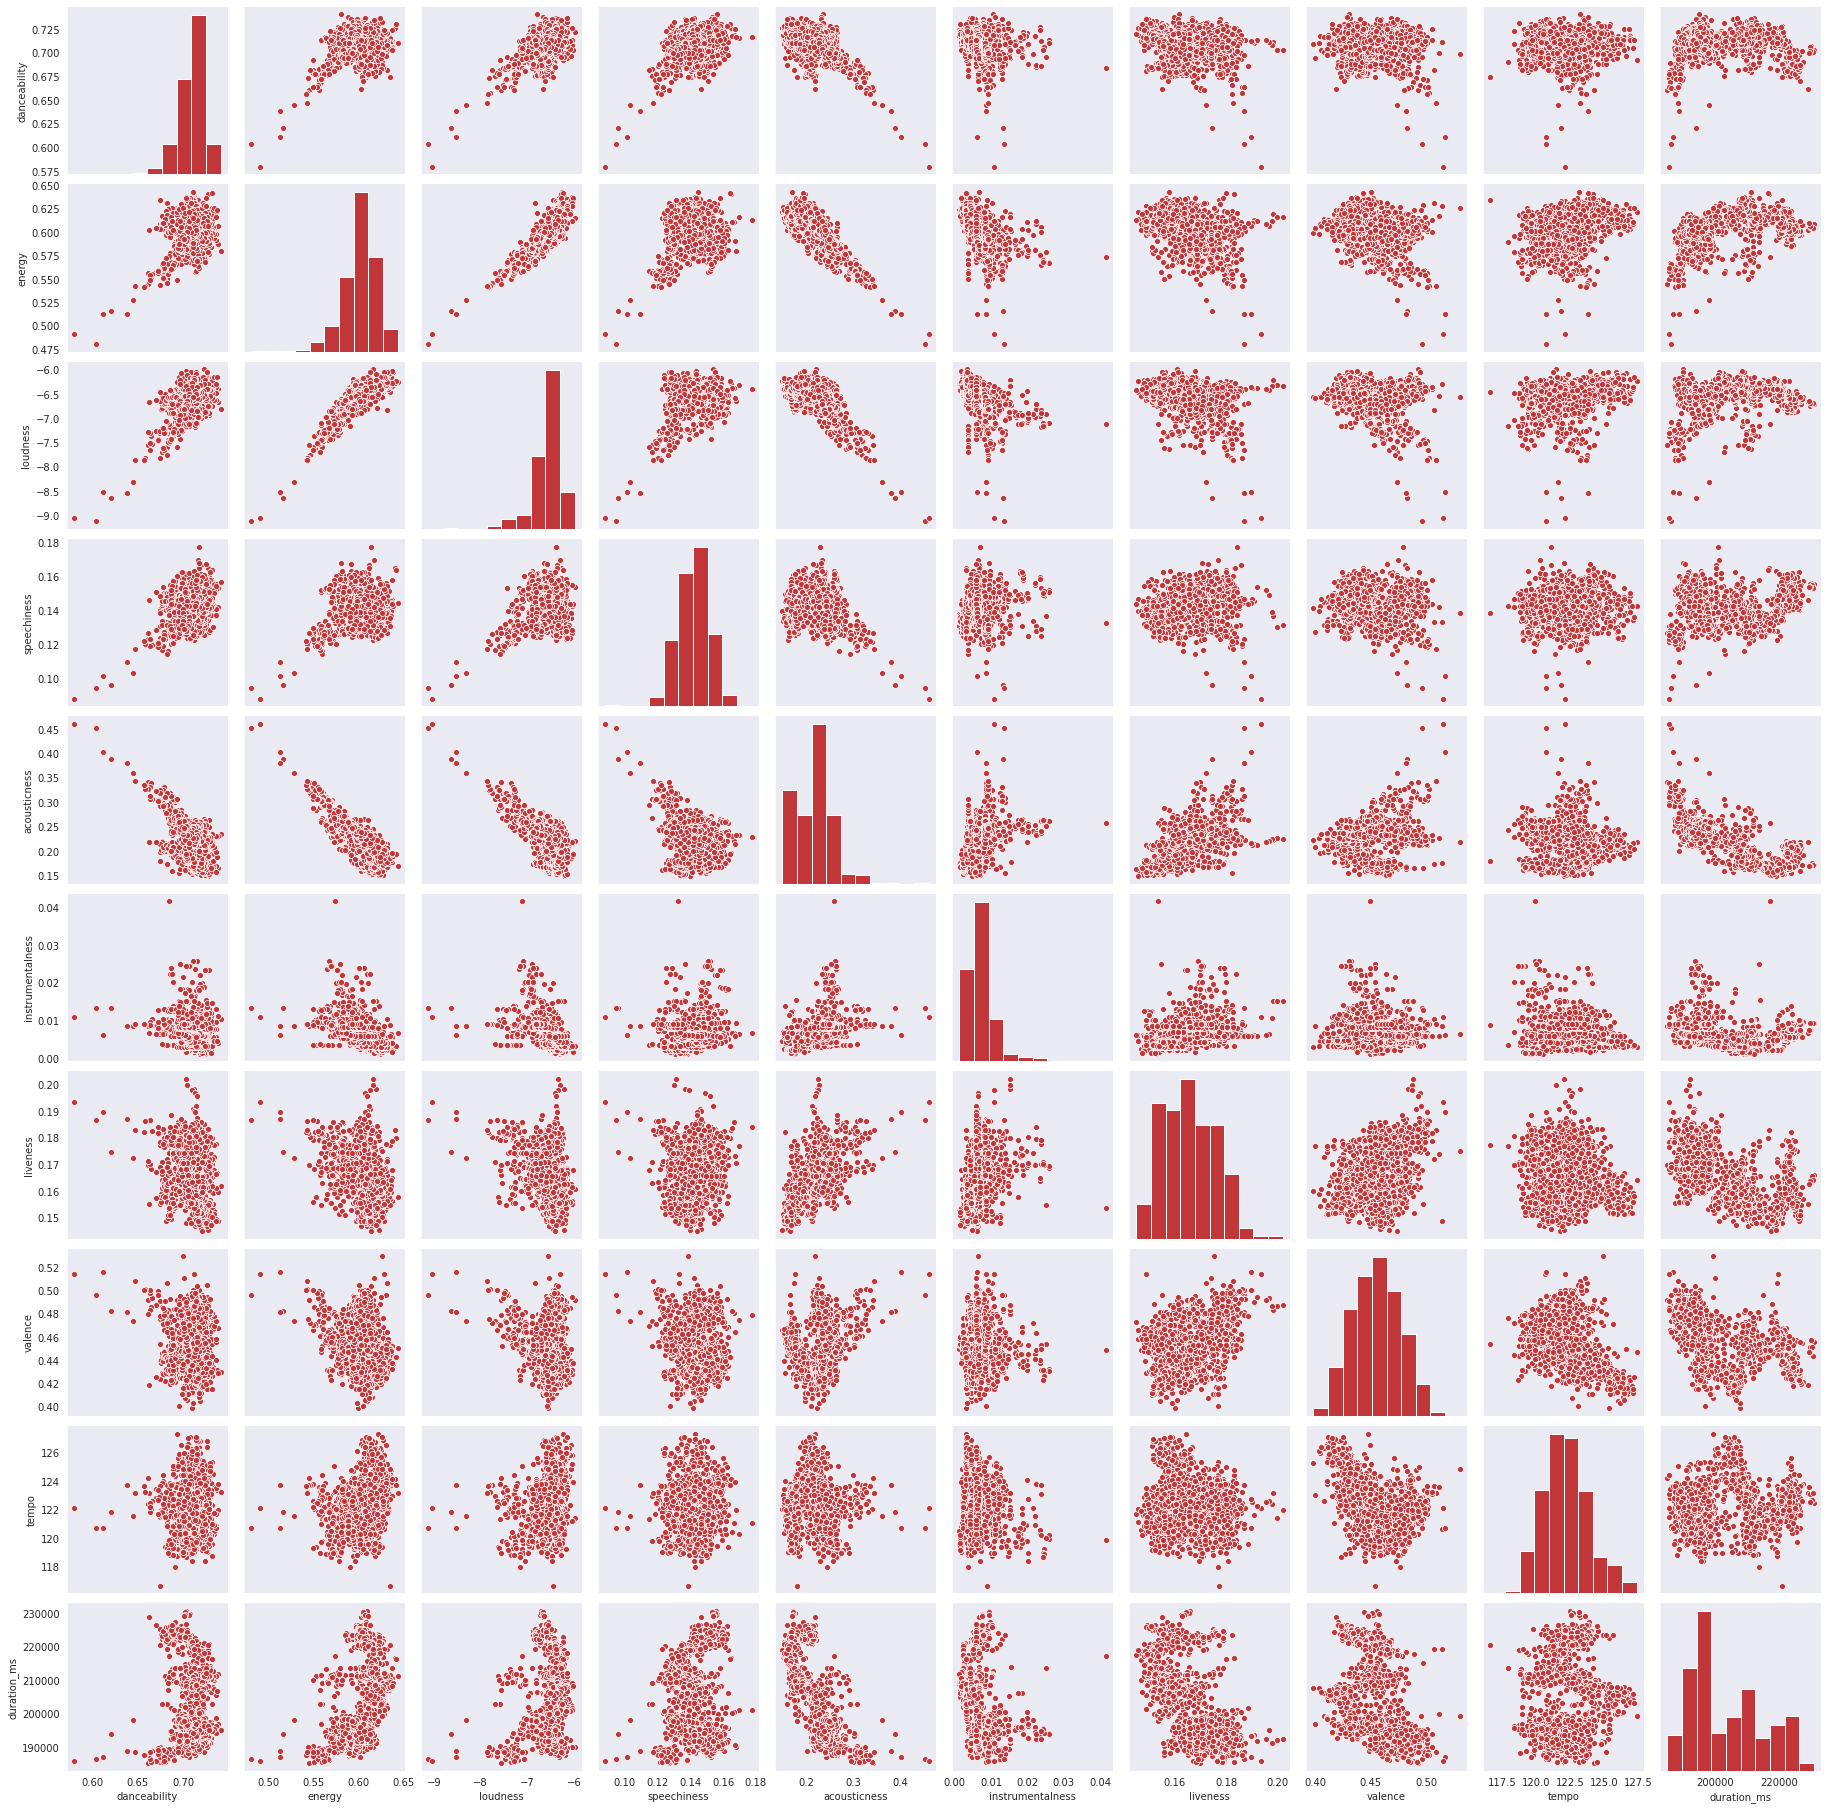

In [20]:
sns.pairplot(attributes_only)

## Boxplots for all song Attributes
The below section summarizes the distrubtion of each audio feature in the 1365 day timeperiod.

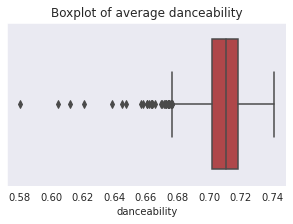

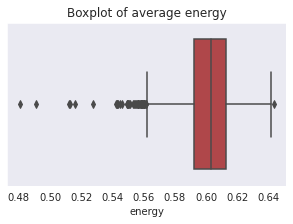

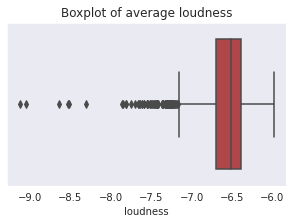

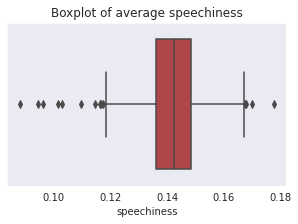

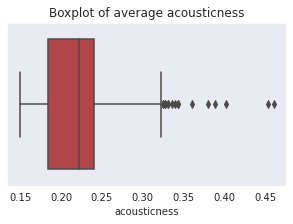

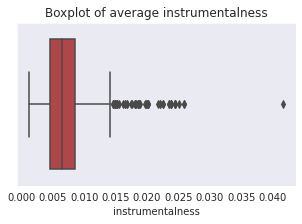

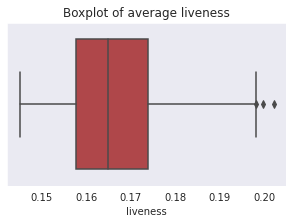

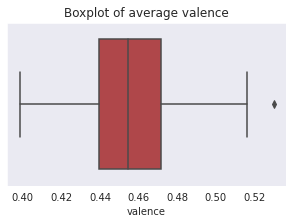

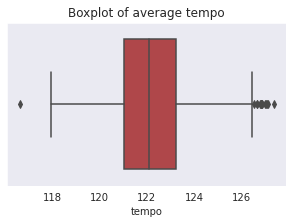

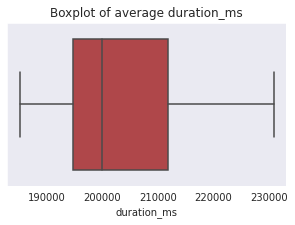

In [21]:
#Distribution of each audio feature
for feature in attributes_only.columns:
    fig, ax = plt.subplots(figsize=(5,3))
    ax.set_title('Boxplot of average ' + str(feature))
    sns.boxplot(ax=ax, x=top_avg[feature])
    plt.show()

# Google Trends Data
For the purposes of this research project, we will be using Google Trends data in order to analize the relationship between music attributes and search term frequency as it relates to search terms indicative of negative mental health

## Define a set of terms related to mental health disorders:
Here, our set is based on the clinically verified set used in [Jacobson et. al. 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7265799/#app1)

From that publication:
We used the following search terms to examine common mental health symptoms: “anxiety,” “depression,” “OCD” (obsessive-compulsive disorder), “hopeless,” “angry,” “afraid,” “apathy,” “worthless,” “worried,” “restless,” “irritable,” “tense,” “scattered,” “tired,” “avoiding,” “procrastinate,” “insomnia,” “suicidal,” and “suicide.” [These mental health terms were validated by prior research on mental health using Google Trends](https://mental.jmir.org/2019/4/e12974/). 

In [22]:
pytrend = TrendReq()

In [23]:
negative_mental_health_corpus = ["anxiety", "depression", "OCD", "hopeless", "angry", "afraid", 
                                 "apathy", "worthless", "worried", "restless", "irritable", 
                                 "tense", "scattered", "tired", "avoiding", "procrastinate", 
                                 "insomnia", "suicidal", "suicide" ]

In [26]:
# Set time frame:
start_date = date(2017, 1, 1)
end_date = date(2020, 9, 29)
timeframe = '{} {}'.format(date_as_string(start_date), date_as_string(end_date))

In [27]:
# Collect only data from the United States:
loc = 'US'

In [28]:
# Create a pandas dataframe to store search term freuqency data in
search_term_frequency = pd.DataFrame()

In [29]:
# Google trends can only get data on 4 key words at a time (len(kw_list) <= 4)
for i in range(0, len(negative_mental_health_corpus), 4): # increment by 4

    search_terms = negative_mental_health_corpus[i:i+4]
    pytrend.build_payload(kw_list=search_terms, timeframe=timeframe, geo=loc)
    interest_over_time = pytrend.interest_over_time()
    partial = interest_over_time.pop("isPartial")
    
    # Add terms to larger dataframe
    search_term_frequency = pd.concat([search_term_frequency, interest_over_time], axis=1)
    
    # If any of the terms includes partial data, then that entire day's data is partial
    search_term_frequency['isPartial'] = partial

In [30]:
# Move 'isPartial' column to the last column so we are sure we can see it
col = search_term_frequency.pop("isPartial")
search_term_frequency.insert(len(search_term_frequency.columns), col.name, col)

# Make sure that date is registered as a data attribute, not indices of the data:
search_term_frequency.reset_index(level=0, inplace=True)

In [31]:
num_impartial_samples = len(search_term_frequency[search_term_frequency['isPartial'] == True])
print("Num impartial samples = ", num_impartial_samples)

Num impartial samples =  0


In [32]:
search_term_frequency.head()

,date,anxiety,depression,OCD,hopeless,angry,afraid,apathy,worthless,worried,...,irritable,tense,scattered,tired,avoiding,procrastinate,insomnia,suicidal,suicide,isPartial
0,2017-01-01,79,69,10,2,69,26,4,3,6,...,4,19,3,76,6,3,7,3,52,False
1,2017-01-08,78,78,11,2,69,31,5,3,6,...,5,26,3,80,6,3,7,3,51,False
2,2017-01-15,82,78,11,2,71,28,5,3,7,...,5,25,3,81,7,3,7,3,40,False
3,2017-01-22,88,87,10,2,72,27,6,2,7,...,5,29,4,90,8,3,8,3,41,False
4,2017-01-29,80,84,11,2,69,26,6,3,8,...,6,28,4,99,8,3,8,3,37,False


## Generate a 'Mental Health' Metric 
which sums up the search frequency for all terms defined in our corpus of negative-mental-health-related words

In [33]:
# Sum of google trends scores for all searches in the negative mental health corpus
term_scores_summed = search_term_frequency.drop(columns=['isPartial', 'date']).sum(axis=1)
search_term_frequency['Term Scores Summed'] = term_scores_summed

## Graph Data

### Histograms of All Search Terms

In [34]:
terms_only = search_term_frequency.drop(columns=['isPartial', 'date'])

Histograms for All Search Terms


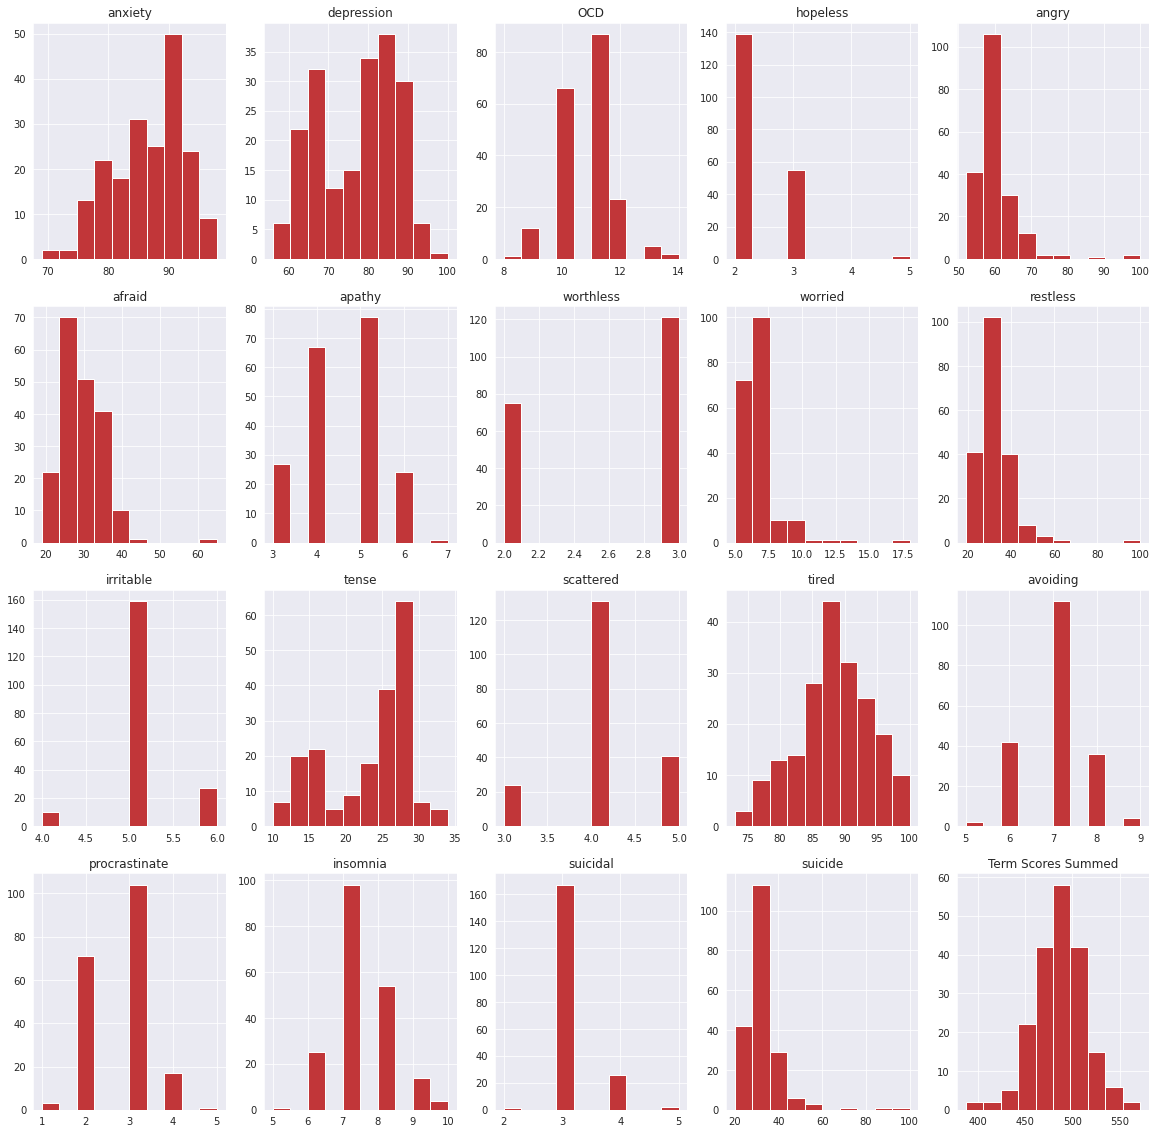

In [35]:
print('Histograms for All Search Terms')
for n, col in enumerate(terms_only.columns):
    plt.subplot(4, 5, n+1)
    plt.title(col)
    terms_only[col].hist(ax = plt.gca(), figsize=(20, 20))

### Boxplots of all search terms
These graphs reflect the spread of the search score across each search term

Boxplots for All Search Terms


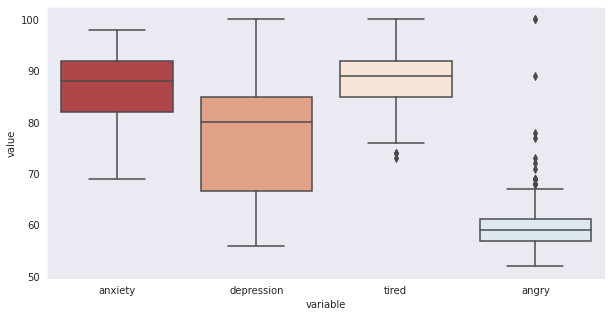

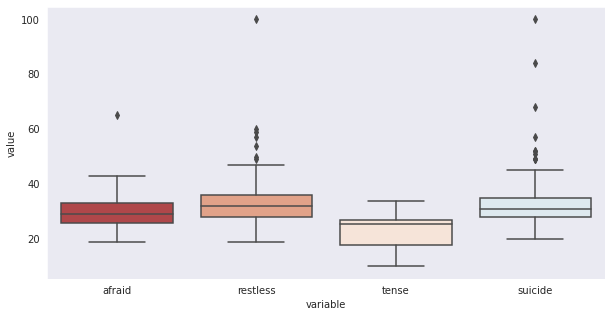

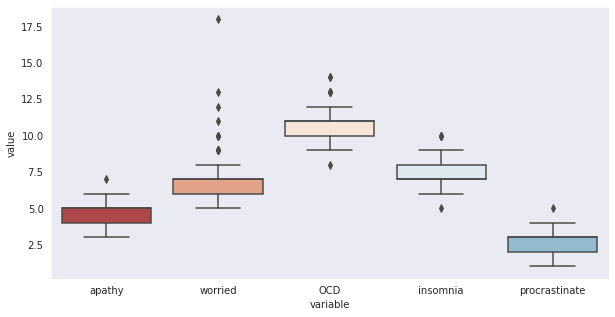

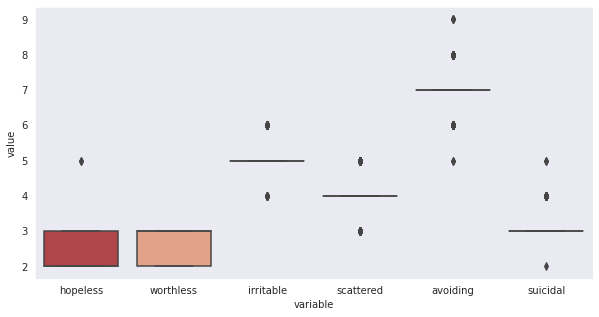

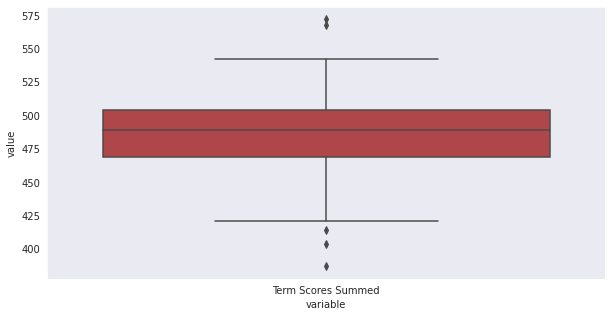

In [36]:
# Boxplots:
print('Boxplots for All Search Terms')
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, x="variable", y="value", data=pd.melt(terms_only[['anxiety', 'depression', 
                                                                     'tired', 'angry']]))
plt.show()
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, x="variable", y="value", data=pd.melt(terms_only[['afraid', 'restless', 
                                                                     'tense', 'suicide']]))
plt.show()
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, x="variable", y="value", data=pd.melt(terms_only[['apathy', 'worried', 'OCD', 
                                                                     'insomnia', 'procrastinate']]))
plt.show()
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, x="variable", y="value", data=pd.melt(terms_only[['hopeless', 'worthless', 'irritable', 
                                                                     'scattered', 'avoiding', 'suicidal']]))
plt.show()
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(ax=ax, x="variable", y="value", data=pd.melt(terms_only[['Term Scores Summed']]))
plt.show()

### Time series plots for term scores

Individual Search Terms - Time Series


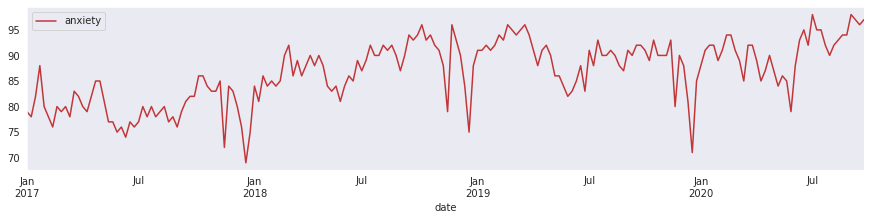

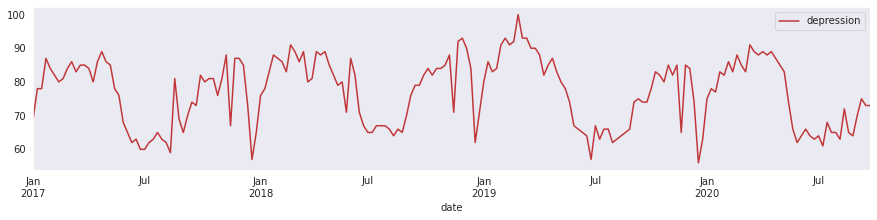

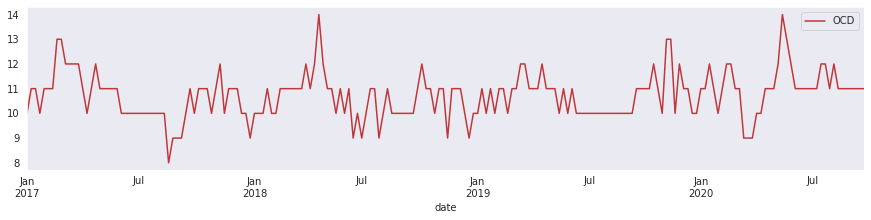

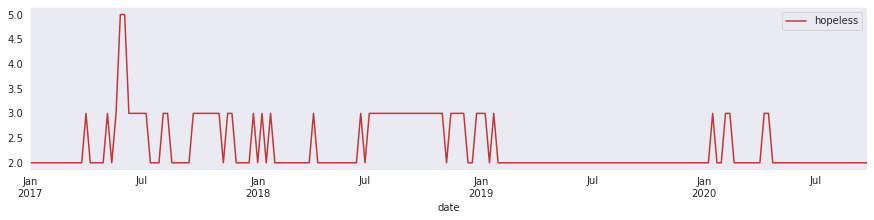

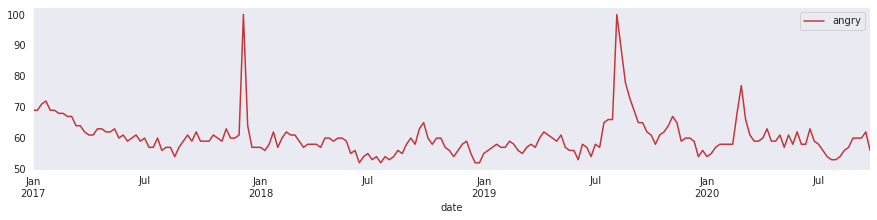

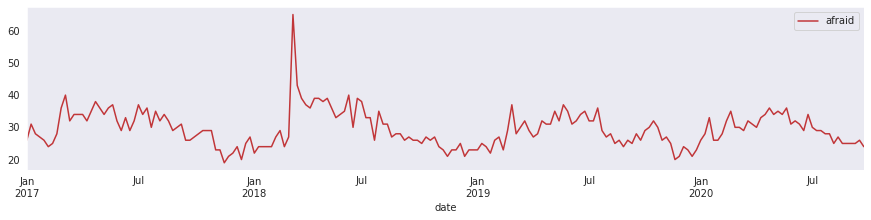

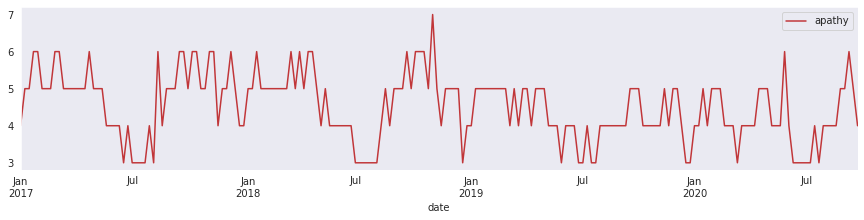

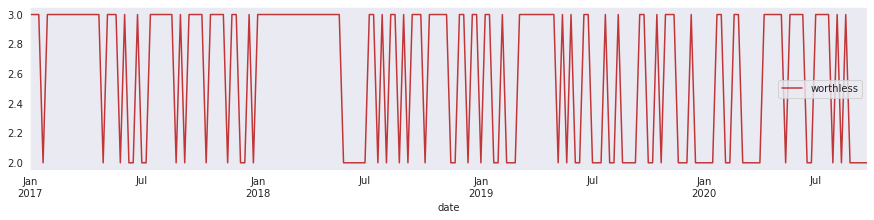

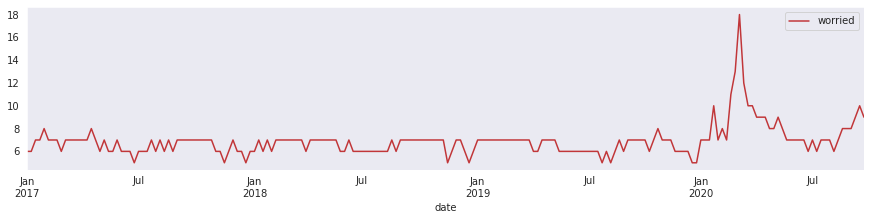

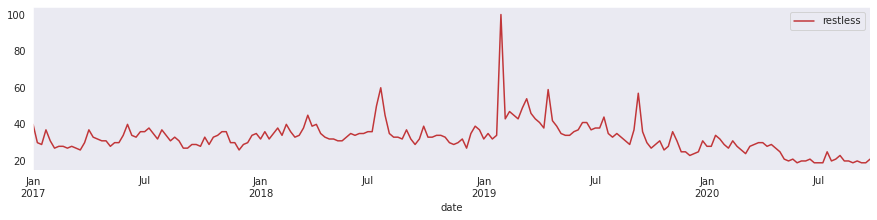

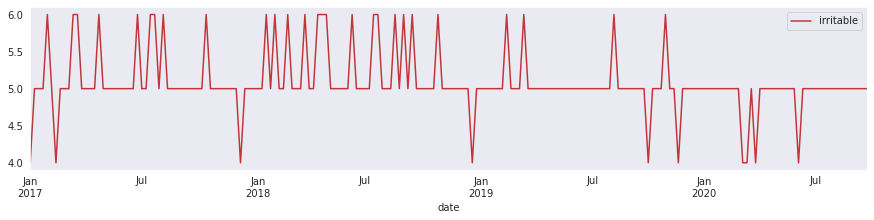

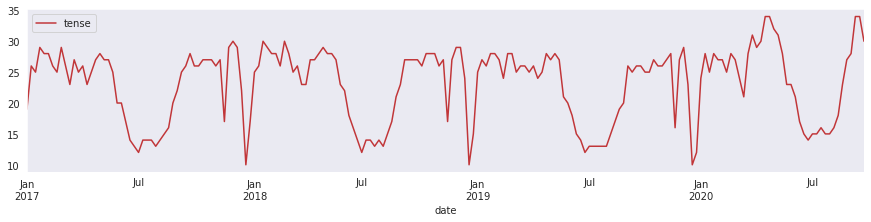

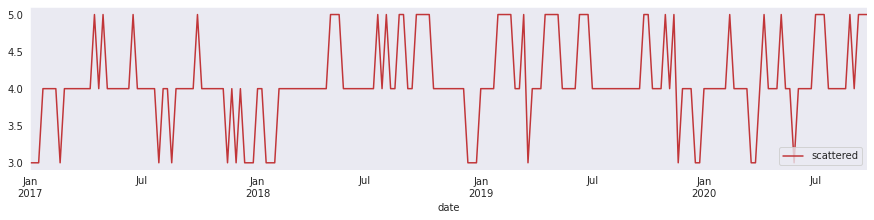

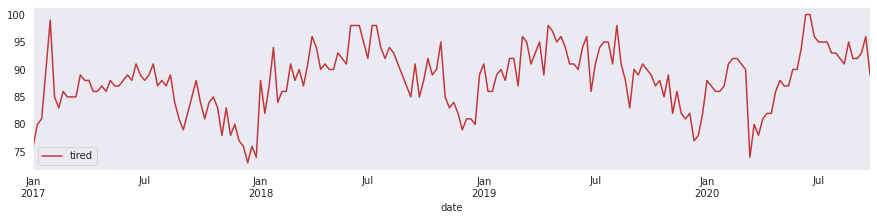

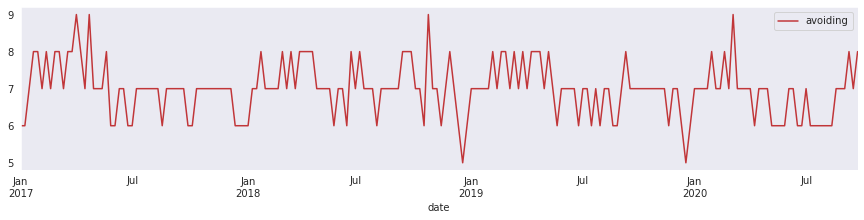

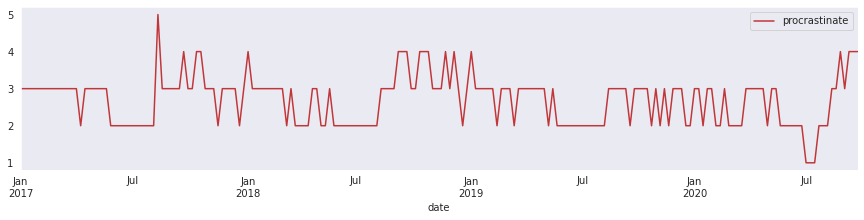

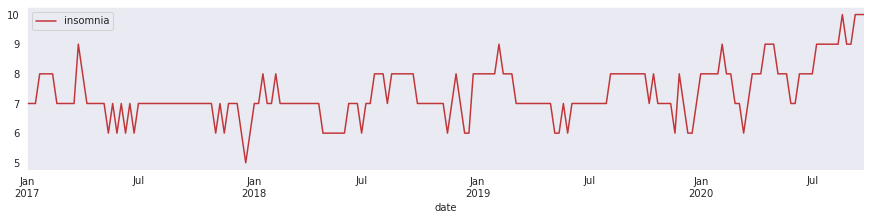

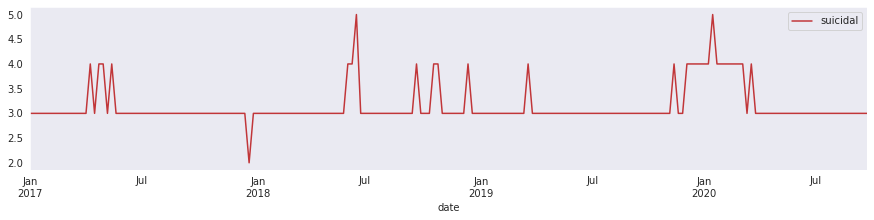

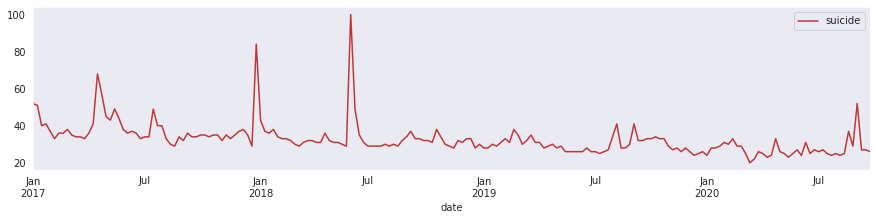

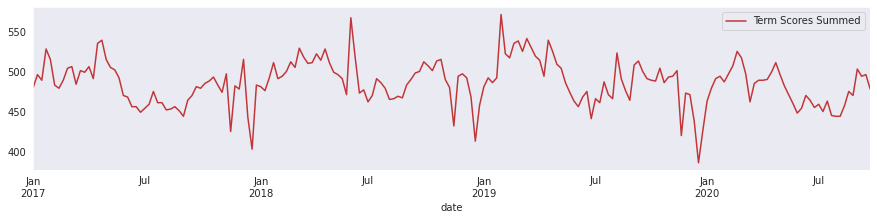

In [37]:
# Each term individually
print('Individual Search Terms - Time Series')
for i, term in enumerate(search_term_frequency.columns):
    if term != 'date' and term != 'isPartial':
        search_term_frequency.plot.line(x='date', y=term, figsize=(15,3))
        plt.show()

Search Terms Side-by-side - Time Series


<AxesSubplot:xlabel='date'>

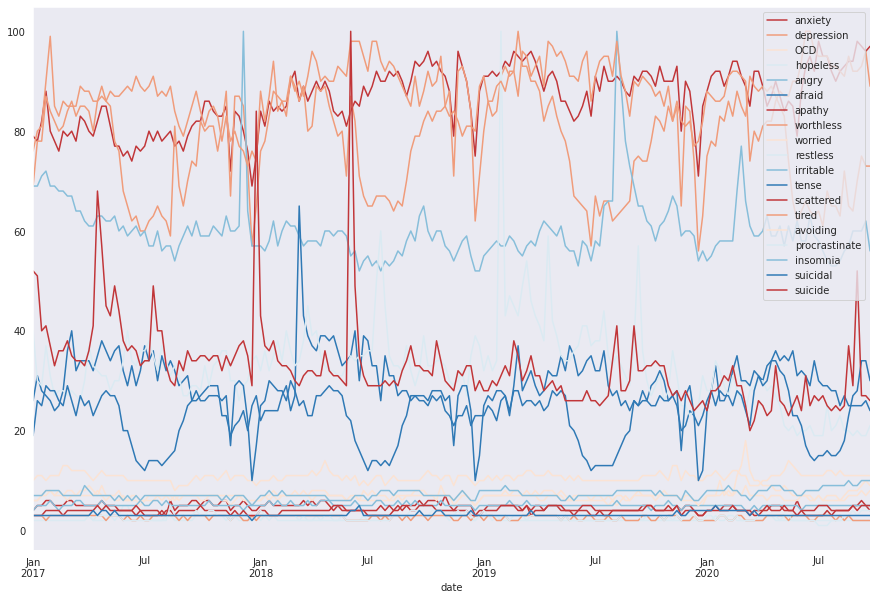

In [38]:
# All terms together
print('Search Terms Side-by-side - Time Series')
search_term_frequency.drop(columns=['Term Scores Summed']).set_index('date').plot(figsize=(15,10))